In [216]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import librosa
import python_speech_features as psf
from scipy.fftpack import dct, idct
# source:
# much of this is taken from this link:
# https://github.com/jameslyons/python_speech_features/blob/master/python_speech_features/base.py

In [217]:
def plot_mfccs(mfccs, n_mfcc):
    num_rows, num_cols = mfccs.shape
    t = range(0, num_cols)
    n_mfcc = 3 if n_mfcc < 0 else min(n_mfcc, num_rows)
    colors = cm.rainbow(np.linspace(0, 1, n_mfcc))
    patches = []
    for i in range(0, n_mfcc):
        patch = mpatches.Patch(color=colors[i], label='mfcc #{0:01d}'.format(i))
        patches.append(patch)
    plt.legend(handles=patches, loc='center right')
    for i in range(0, n_mfcc):
        plt.plot(t, mfccs[i], color=colors[i], linewidth=3)
    plt.show()

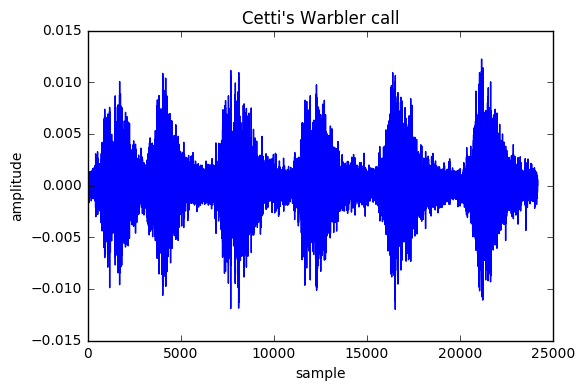

In [218]:
lark_path_1 = "../zShortBirdRecordings/trainfile016_CettisWarbler03.wav"
lark_signal, lark_sample_rate = librosa.load(lark_path_1)
plt.plot(lark_signal)
plt.title("Cetti's Warbler call")
plt.xlabel("sample")
plt.ylabel("amplitude")
plt.show()

In [219]:
# constants
window_length = 0.025
window_step = 0.01
n_filters = 12
nfft = 512
preemph=0.97
ceplifter=22

In [220]:
highfreq = lark_sample_rate/2
signal = psf.sigproc.preemphasis(lark_signal,preemph)
frames = psf.sigproc.framesig(signal, window_length*lark_sample_rate, window_step*lark_sample_rate, winfunc=lambda x:np.ones((x,)))
pspec = psf.sigproc.powspec(frames,nfft)
energy = np.sum(pspec,1) # this stores the total energy in each frame
energy = np.where(energy == 0,np.finfo(float).eps,energy) # if energy is zero, we get problems with log

In [221]:
ith_frame_to_show = 5

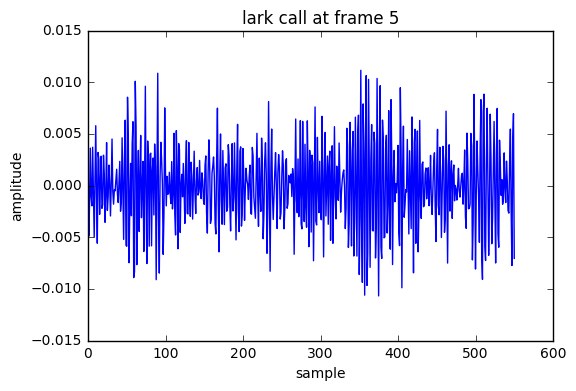

In [222]:
plt.plot(frames[ith_frame_to_show])
plt.title("lark call at frame {0:0d}".format(ith_frame_to_show))
plt.xlabel("sample")
plt.ylabel("amplitude")
plt.show()

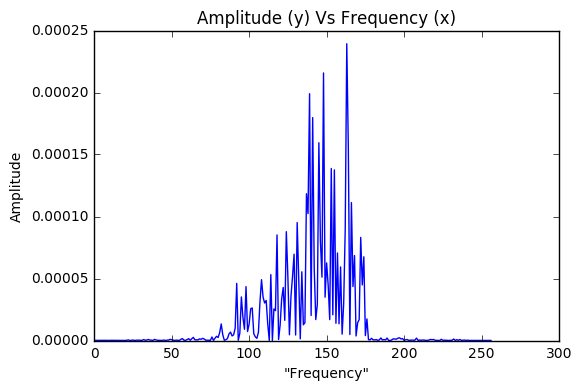

In [223]:
plt.plot(pspec[ith_frame_to_show])
plt.title("Amplitude (y) Vs Frequency (x)")
plt.xlabel("\"Frequency\"")
plt.ylabel("Amplitude")
plt.show()

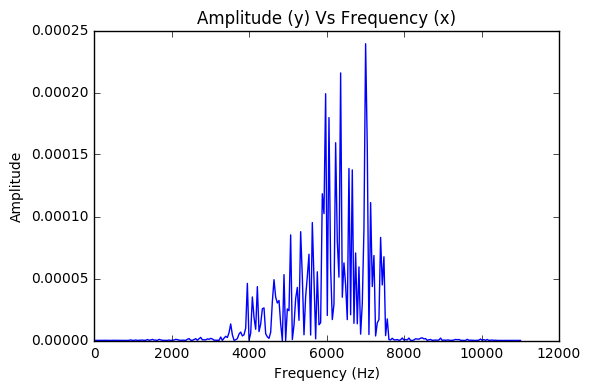

In [224]:
the_x_axis = [(x * lark_sample_rate) / float(nfft+1) for x in range(0, len(pspec[ith_frame_to_show]))]
plt.plot(the_x_axis, pspec[ith_frame_to_show])
plt.title("Amplitude (y) Vs Frequency (x)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

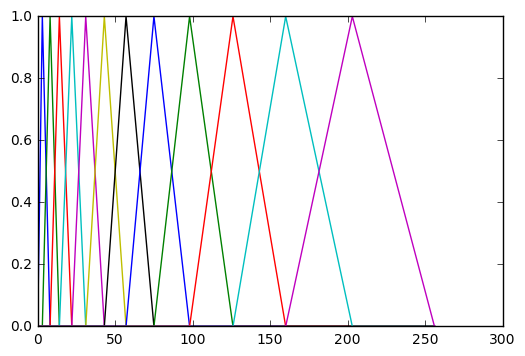

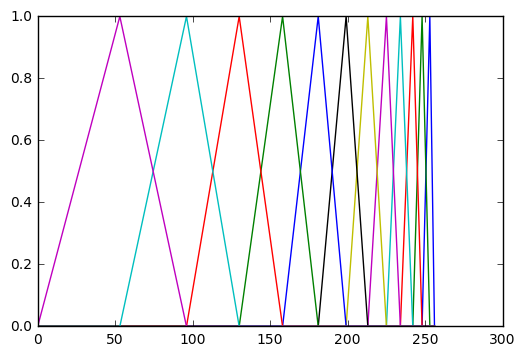

(12, 257)


In [225]:
filter_banks = psf.get_filterbanks(nfilt=n_filters, nfft=nfft, samplerate=lark_sample_rate)
flipped_filter_banks = np.array([np.flipud(filt_bank) for filt_bank in filter_banks])
x_range = range(0, filter_banks.shape[1])

# plot regular mel-spaced filterbanks
for i in range(0, filter_banks.shape[0]):
    plt.plot(x_range, filter_banks[i])
plt.show()

for i in range(0, flipped_filter_banks.shape[0]):
    plt.plot(x_range, flipped_filter_banks[i])
plt.show()
print(filter_banks.shape)

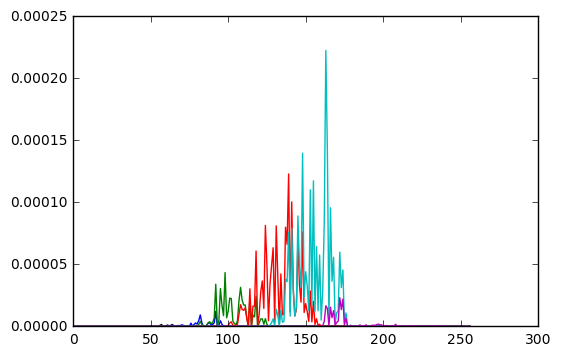

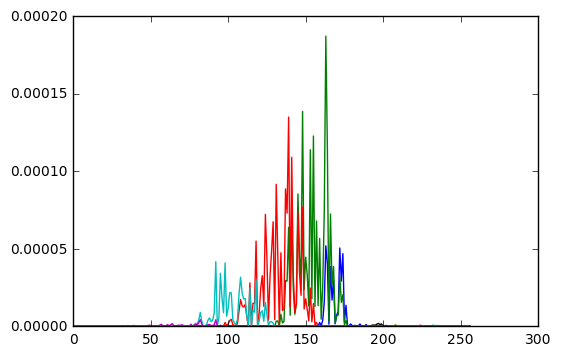

In [226]:
ith_pspec = pspec[ith_frame_to_show]
#print(type(ith_frame))
#print(type(filter_banks))
signal_transformed_mel = [ith_pspec * filter_banks[filter_bank_index] for filter_bank_index in range(0, len(filter_banks))]
for i in range(0, len(signal_transformed_mel)):
    plt.plot(signal_transformed_mel[i])
plt.show()
signal_tranformed_mel_flipped = [ith_pspec * flipped_filter_banks[filter_bank_index] for filter_bank_index in range(0, len(flipped_filter_banks))]
for i in range(0, len(signal_tranformed_mel_flipped)):
    plt.plot(signal_tranformed_mel_flipped[i])
plt.show()

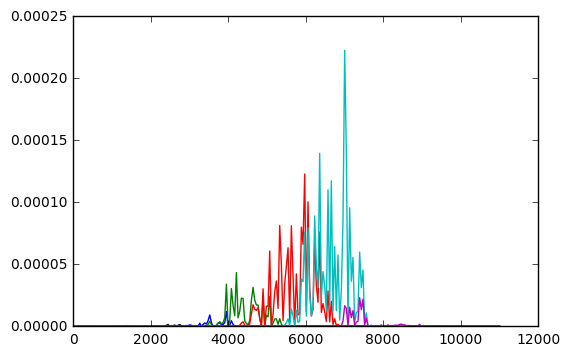

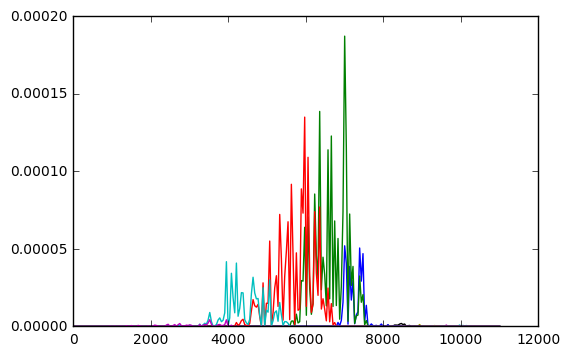

In [227]:
ith_pspec = pspec[ith_frame_to_show]
#print(type(ith_frame))
#print(type(filter_banks))
signal_transformed_mel = [ith_pspec * filter_banks[filter_bank_index] for filter_bank_index in range(0, len(filter_banks))]
for i in range(0, len(signal_transformed_mel)):
    plt.plot(the_x_axis, signal_transformed_mel[i])
plt.show()

signal_tranformed_mel_flipped = [ith_pspec * flipped_filter_banks[filter_bank_index] for filter_bank_index in range(0, len(flipped_filter_banks))]
for i in range(0, len(signal_tranformed_mel_flipped)):
    plt.plot(the_x_axis, signal_tranformed_mel_flipped[i])
plt.show()

In [228]:
feat = np.dot(pspec, filter_banks.T) # compute the filterbank energies
feat = np.where(feat == 0, np.finfo(float).eps, feat) # if feat is zero, we get problems with log

feat_flipped = np.dot(pspec, flipped_filter_banks.T) # compute the filterbank energies
feat_flipped = np.where(feat_flipped == 0, np.finfo(float).eps, feat_flipped) # if feat is zero, we get problems with log

In [229]:
print(feat.shape)

(108, 12)


In [230]:
n_mfcc = 6
# MFCC step
log_feat = np.log(feat)
mfcc_coeffs = dct(log_feat, type=2, axis=1, norm='ortho')[:, :n_mfcc]

log_feat_flipped = np.log(feat_flipped)
mfcc_coeffs_flipped_fbs = dct(log_feat_flipped, type=2, axis=1, norm='ortho')[:, :n_mfcc]

In [232]:
mfcc_coeffs = psf.lifter(mfcc_coeffs,ceplifter)
mfcc_coeffs[:,0] = np.log(energy)
mfcc = mfcc_coeffs.T

mfcc_coeffs_flipped = psf.lifter(mfcc_coeffs_flipped_fbs, ceplifter)
mfcc_coeffs_flipped[:,0] = np.log(energy)
mfcc_flipped_fbs = mfcc_coeffs_flipped.T

In [233]:
print(mfcc.shape)

(6, 108)


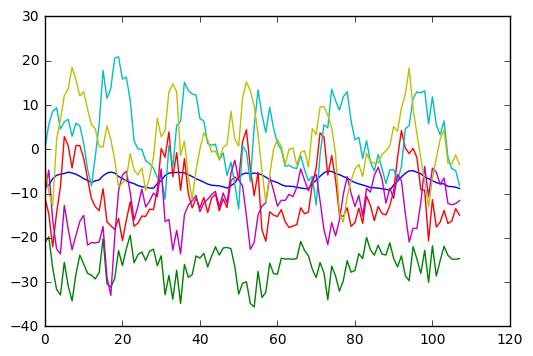

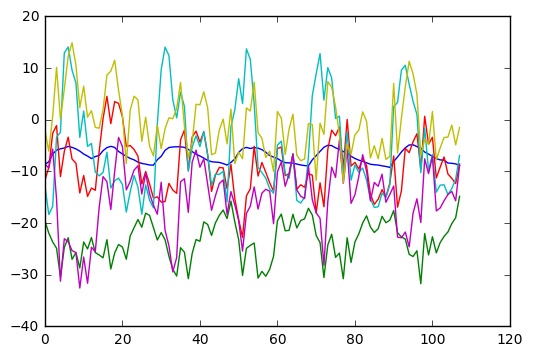

In [234]:
for i in range(0, mfcc.shape[0]):
    plt.plot(mfcc[i])
plt.show()

for i in range(0, mfcc_fliped_fbs.shape[0]):
    plt.plot(mfcc_flipped_fbs[i])
plt.show()